In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

In [27]:
df = pd.read_csv('../..//Data/energy/train.csv', encoding='cp949')

generation = pd.read_csv('../../Data/capstone/발전소/한국남부발전(주)_하동보건소 태양광발전실적_20220630.csv', encoding='cp949')

In [43]:
gen_start = pd.to_datetime('2013-01-01 01:00:00')
gen_end = pd.to_datetime('2022-07-01 00:00:00')

In [48]:
gen = pd.DataFrame(generation.drop(['년월일'], axis=1).values.reshape(-1, 1), columns=['generation'])

In [49]:
gen['time'] = pd.date_range(start=gen_start, end=gen_end, freq='H')

In [7]:
df['date_time'] = pd.to_datetime(df['date_time'])

eda_df = df.copy()

eda_df['month'] = eda_df['date_time'].dt.month
eda_df['day'] = eda_df['date_time'].dt.day
eda_df['hour'] = eda_df['date_time'].dt.hour
eda_df['요일'] = eda_df['date_time'].dt.dayofweek

In [13]:
longitude = 127.752977
latitude = 35.066767

In [66]:
input_col = ['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','month', 'hour']

In [68]:
gen['time']

0       2013-01-01 01:00:00
1       2013-01-01 02:00:00
2       2013-01-01 03:00:00
3       2013-01-01 04:00:00
4       2013-01-01 05:00:00
                ...        
83227   2022-06-30 20:00:00
83228   2022-06-30 21:00:00
83229   2022-06-30 22:00:00
83230   2022-06-30 23:00:00
83231   2022-07-01 00:00:00
Name: time, Length: 83232, dtype: datetime64[ns]

In [88]:
eda_df = eda_df[(eda_df['date_time'] >= gen['time'].min()) & (eda_df['date_time'] <= gen['time'].max())].reset_index(drop = True)

In [119]:
total_df = eda_df[eda_df['num'] == 10]

In [120]:
gen_eda = gen[gen['time'].isin(eda_df['date_time'])].reset_index(drop=True)

---
# DNI, DHI, GHI 생성

In [121]:
start_date = eda_df['date_time'].min()
end_date = eda_df['date_time'].max()

In [122]:
tus = Location(latitude, longitude, 'ROK')

time_range = pd.date_range(start=start_date, end = end_date, freq='H', tz = tus.tz)

In [123]:
cs = tus.get_clearsky(time_range)

<Axes: >

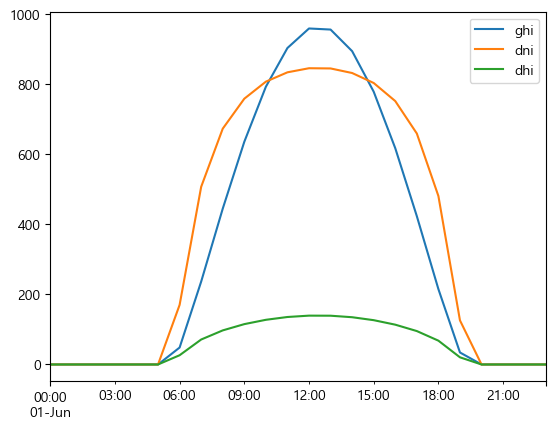

In [124]:
cs[:24].plot()

In [125]:
total_df[['GHI', 'DNI', 'DHI']] = cs[['ghi', 'dni', 'dhi']].values

----
# 태양광 예측 모델 생성
물리 반영 vs 데이터 드리븐

In [126]:
x_none = total_df[input_col]
y = gen_eda['generation']

x_physics = total_df[input_col + ['GHI', 'DNI', 'DHI']]

In [127]:
train_size = int(len(x_none) * 0.8)
x_none_train = x_none[:train_size]
x_none_test = x_none[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

x_physics_train = x_physics[:train_size]
x_physics_test = x_physics[train_size:]

In [128]:
mn_none = MinMaxScaler()
mn_physics = MinMaxScaler()

In [129]:
sc_x_none_train = mn_none.fit_transform(x_none_train)
sc_x_none_test = mn_none.transform(x_none_test)

sc_x_physics_train = mn_physics.fit_transform(x_physics_train)
sc_x_physics_test = mn_physics.transform(x_physics_test)

In [130]:
rf_model_none = RandomForestRegressor(n_estimators=300, random_state=42)
lgb_model_none = lgb.LGBMRegressor(n_estimators=300, random_state=42)

rf_model_physics = RandomForestRegressor(n_estimators=300, random_state=42)
lgb_model_physics = lgb.LGBMRegressor(n_estimators=300, random_state=42)

In [131]:
rf_model_none.fit(sc_x_none_train, y_train)
rf_pred_none = rf_model_none.predict(sc_x_none_test)

lgb_model_none.fit(sc_x_physics_train, y_train)
lgb_pred_none = lgb_model_none.predict(sc_x_physics_test)

rf_model_physics.fit(sc_x_physics_train, y_train)
rf_pred_physics = rf_model_physics.predict(sc_x_physics_test)

lgb_model_physics.fit(sc_x_physics_train, y_train)
lgb_pred_physics = lgb_model_physics.predict(sc_x_physics_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 10
[LightGBM] [Info] Start training from score 5.233502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 10
[LightGBM] [Info] Start training from score 5.233502


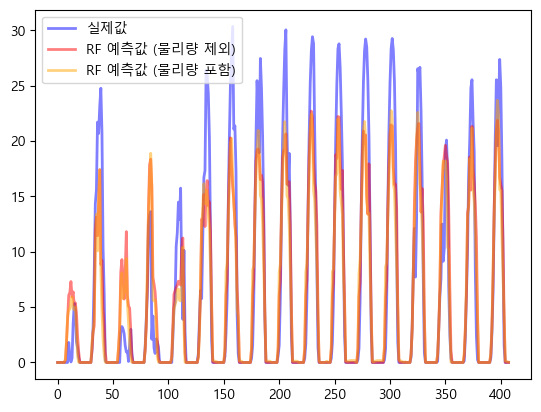

In [132]:
plt.plot(y_test.values, label='실제값', color='blue'
         , alpha=0.5, linewidth=2)
plt.plot(rf_pred_none, label='RF 예측값 (물리량 제외)', color='red'
            , alpha=0.5, linewidth=2)
# plt.plot(lgb_pred_none, label='LGBM 예측값 (물리량 제외)', color='green'
#             , alpha=0.5, linewidth=2)
plt.plot(rf_pred_physics, label='RF 예측값 (물리량 포함)', color='orange'
            , alpha=0.5, linewidth=2)
# plt.plot(lgb_pred_physics, label='LGBM 예측값 (물리량 포함)', color='purple'
#             , alpha=0.5, linewidth=2)
plt.legend()
plt.show()

In [133]:
print('RF None:',r2_score(y_test, rf_pred_none))
print('RF Physics:',r2_score(y_test, rf_pred_physics))

print('LGBM None:',r2_score(y_test, lgb_pred_none))
print('LGBM Physics:',r2_score(y_test, lgb_pred_physics))

RF None: 0.8294732113064961
RF Physics: 0.8063695744944571
LGBM None: 0.7764610567357947
LGBM Physics: 0.7764610567357947
